2.2) Deixe apenas $\Omega_m$ como parâmetro livre e assuma um valor de $H_0$ (o valor da tabela do Planck).

Valor de $H_0$ na tabela do Planck: $H_0 = 67.27 +- 0.60$

In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, Galactic,  cartesian_to_spherical
import matplotlib.pyplot as plt
from healpy import projview

import pyccl as ccl
from scipy import integrate
import pyccl as ccl
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
# Definir os parâmetros de pixelização
nside = 4
npix = hp.nside2npix(nside)

In [3]:
# Obter as coordenadas dos centros dos pixels para nside=4
lon, lat = hp.pix2ang(nside, range(npix), lonlat=True)

galactic_coords = SkyCoord(l=lon, b=lat, frame='galactic', unit='deg')
equatorial_coords = galactic_coords.icrs

ra_pixel = equatorial_coords.ra.deg
dec_pixel = equatorial_coords.dec.deg

In [4]:
# Ler os dados
data = pd.read_csv('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES.csv', sep=' ')

In [5]:
#Acrescentando uma tabela de índices à tabela

index = []
for i in range(1701):
    index.append(i)
    
data['index'] = index

In [6]:
data

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD,index
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003,0
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004,1
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036,2
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040,3
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,106,1.61505,0.00545,1.61499,0.00500,1.61399,0.00500,25.90650,0.331927,...,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002,1696
1697,geta,106,1.69706,0.04006,1.69702,0.04000,1.70000,0.04000,26.03330,0.379521,...,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000,1697
1698,stone,106,1.80119,0.02014,1.80111,0.02000,1.80000,0.02000,26.23350,0.280685,...,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000,1698
1699,wilson,106,1.91165,0.00263,1.91160,0.00100,1.91401,0.00100,26.17030,0.357624,...,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000,1699


In [19]:
# Definir o conjunto com zmin = 0.1 e zmax = 1.0
data1 = data[(data['zCMB'] >= 0.1) & (data['zCMB'] <= 1.0)]
print(len(data1))

935


In [20]:
ra_data1 = data1['RA'] * np.pi / 180
dec_data1 = data1['DEC'] * np.pi / 180

In [21]:
# Raio do círculo em graus
raio = 90

n = 191
cont = 0

while cont <= n:
    # Coordenadas do centro do círculo/pixel em radianos
    ra_centro1 = ra_pixel[cont] * np.pi / 180
    dec_centro1 = dec_pixel[cont] * np.pi / 180
    
    # Usando a fórmula de Haversine
    delta_ra1 = ra_data1 - ra_centro1
    delta_dec1 = dec_data1 - dec_centro1
    
    a = np.sin(delta_dec1 / 2)**2 + np.cos(dec_centro1) * np.cos(dec_data1) * np.sin(delta_ra1 / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distancia = np.degrees(c)
    objetos1 = data1[distancia <= raio]
    
    local = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 1 Fixo/{cont:03d}.csv'
    objetos1.to_csv(local, index=False)
 
    cont += 1

In [11]:
index1 = []
zCMB1 = []
MU_SHOES1 = []

for i in range(192):
    di = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 1 Fixo/{i:03d}.csv'

    hemis = pd.read_csv(di)
    index1.append(hemis['index'].values)
    zCMB1.append(hemis['zCMB'].values)
    MU_SHOES1.append(hemis['MU_SH0ES'].values)

In [12]:
cove = np.genfromtxt('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES_STAT+SYS.cov', skip_header=1)
cov = np.reshape(cove, (1701, 1701))

In [13]:
# Função modificada para fixar H0
def mu_fit_ccl_fixo(z, Om0):
    H0 = 67.27  # Fixar H0
    h0=H0/100
    cosmo = ccl.Cosmology(
        Omega_c=Om0 - 0.0494, Omega_b=0.0494, 
        h=h0, sigma8=0.8120, n_s=0.9649)
    
    a = 1 / (1 + z)
    return ccl.background.distance_modulus(cosmo, a)

In [14]:
H0_c1 = []
Om_c1 = []

for i in range(192):  
    I_h = np.int64(index1[i])
    E_h = cov[np.ix_(I_h, I_h)]
    
    # Ajustar apenas Omega_m
    curve_c1, cove_c1 = curve_fit(mu_fit_ccl_fixo, zCMB1[i], MU_SHOES1[i], p0=0.3, bounds=([0,1]),sigma=E_h, method='trf')
        
    print(curve_c1)
    H0_c1.append(67.27)  # Fixar H0
    Om_c1.append(curve_c1[0])

[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.6595957]
[0.6595957]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.66858163]
[0.67304692]
[0.67319612]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.65720362]
[0.67568305]
[0.70784603]
[0.70763157]
[0.70763157]
[0.67652029]
[0.65720362]
[0.66865491]
[0.6760864]
[0.6760864]
[0.66761471]
[0.65750344]
[0.65539426]
[0.65539426]
[0.65720362]
[0.65946416]
[0.67326044]
[0.6721619]
[0.69012014]
[0.69122279]
[0.68507026]
[0.70229612]
[0.7079204]
[0.69846822]
[0.70018724]
[0.70596717]
[0.69175117]
[0.68006459]
[0.66470812]
[0.64933079]
[0.66255704]
[0.65783312]
[0.67048088]
[0.68545822]
[0.68836159]
[0.68588399]
[0.68881912]
[0.69866212]
[0.73090424]
[0.71849985]
[0.70963594]
[0.70992154]
[0.70640868]
[0.67370402]
[0.65246992]
[0.64996169]
[0.61685962]
[0.63091984]
[0.67665792]
[0.71118258]
[0.6838262]
[0.68578503]
[0.69238032]
[0.6964947]
[0.7213

In [15]:
nside = 4  
npix = hp.nside2npix(nside) 

H0_map_c1 = np.zeros(npix)
H0_map_c1[:len(H0_c1)] = H0_c1

Om_map_c1 = np.zeros(npix)
Om_map_c1[:len(Om_c1)] = Om_c1

In [16]:
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_1.fits', H0_map_c1, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_1.fits', Om_map_c1, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [17]:
fontsize = {
"xlabel": 15,           # Tamanho da fonte do rótulo do eixo x
"ylabel": 15,           # Tamanho da fonte do rótulo do eixo y
"title": 20,            # Tamanho da fonte do título
"xtick_label": 15,      # Tamanho da fonte dos rótulos do eixo x
"ytick_label": 15,      # Tamanho da fonte dos rótulos do eixo y
"cbar_label": 15,       # Tamanho da fonte da legenda da barra de cores
"cbar_tick_label": 15   # Tamanho da fonte dos rótulos da barra de cores
}

/home/sofia/.local/lib/python3.11/site-packages/healpy/newvisufunc.py:674: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cb = fig.colorbar(


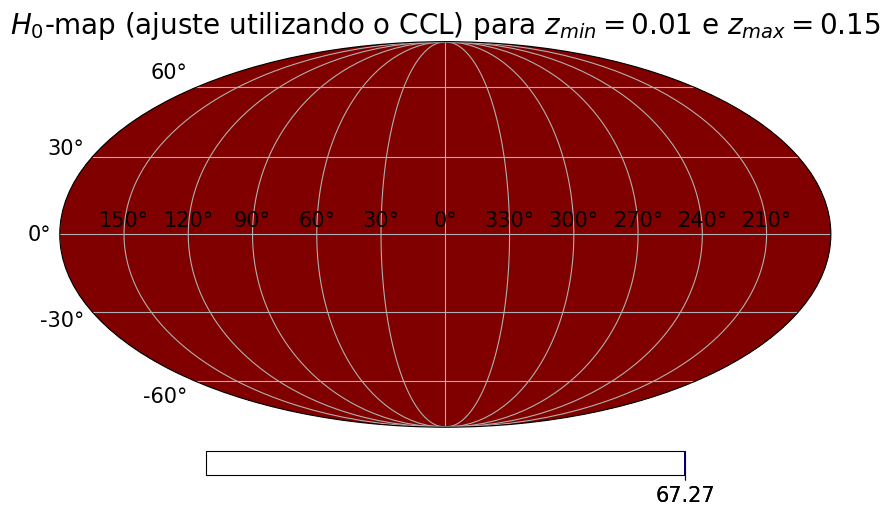

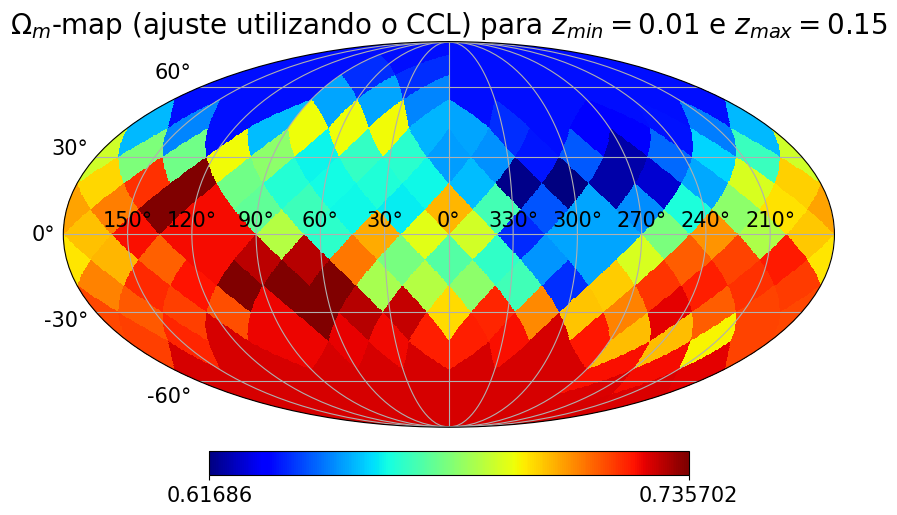

In [18]:
projview(H0_map_c1,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando o CCL) para $z_{min}=0.01$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_1.png', dpi=600, bbox_inches='tight')

plt.show()

projview(Om_map_c1,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando o CCL) para $z_{min}=0.01$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_1.png', dpi=600, bbox_inches='tight')

plt.show()